In [860]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
# Import stats from scipy library
from scipy import stats
import statsmodels.api as sm


from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error


In [676]:
flights_fe = pd.read_csv(r"../data/2_featue_engineered/2_percent.csv")

In [677]:
flights_fe.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,Rank_des,arr_day_of_week,arr_hour,dep_month,dep_day_of_week,dep_hour,arr_type,arr_severity,dep_type,dep_severity
0,2019-01-02,DL,DL_CODESHARE,DL,5303,9E,N606LR,5303,10397,ATL,...,143.0,2,17,1,2,15,Rain,Light,Rain,Light
1,2019-03-26,DL,DL_CODESHARE,DL,5454,9E,N914XJ,5454,10397,ATL,...,143.0,1,12,3,1,10,Rain,Light,Rain,Moderate
2,2019-04-17,DL,DL_CODESHARE,DL,5443,9E,N901XJ,5443,10397,ATL,...,143.0,2,17,4,2,15,Rain,Light,Rain,Light
3,2019-05-12,DL,DL_CODESHARE,DL,5371,9E,N197PQ,5371,10397,ATL,...,143.0,6,12,5,6,10,Rain,Light,Rain,Light
4,2019-06-09,DL,DL_CODESHARE,DL,5197,9E,N916XJ,5197,10397,ATL,...,143.0,6,17,6,6,15,Fog,Moderate,Rain,Light


In [678]:
flights_fe.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled',
       'cancellation_code', 'diverted', 'dup', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'flights', 'distance',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'first_dep_time', 'total_add_gtime',
       'longest_add_gtime', 'no_name', 'arr_date_time', 'dep_date_time',
       'arr_month', 'origin_airport_type', 'dest_airport_type',
       'inbound_flights', 'dep_flights_count', 'arr_flights_count',
       'origin_state', 'dest_state', 'origin_population', 'dest_population',
       'Locid', 'C

## Target variable

<AxesSubplot:ylabel='arr_delay'>

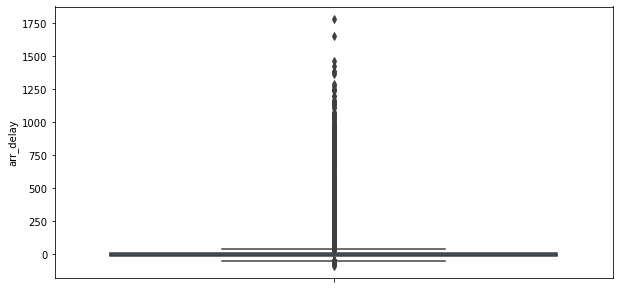

In [679]:
plt.rcParams["figure.figsize"] = (10,5)
sns.boxplot(y=flights_fe.arr_delay)

In [680]:
100*flights_fe.arr_delay.isna().sum()/flights_fe.shape[0]

2.0943555292977436

In [681]:
# drop outliers
flights_fe = flights_fe[~flights_fe.arr_delay.isna()]
flights_fe.arr_delay.isna().sum()/flights_fe.shape[0]

0.0

In [682]:
# Interquartile range (IQR)
IQR = stats.iqr(flights_fe.arr_delay, interpolation = 'midpoint')

# First quartile (Q1)
Q1 = np.percentile(flights_fe.arr_delay, 25, interpolation = 'midpoint')
  
# Third quartile (Q3)
Q3 = np.percentile(flights_fe.arr_delay, 75, interpolation = 'midpoint')
  
print(IQR)

22.0


In [683]:
flights_fe = flights_fe[(flights_fe.arr_delay<(Q3 + 1.5*IQR)) & (flights_fe.arr_delay>(Q1 - 1.5*IQR))]

D:\Anaconda\envs\geo_env\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


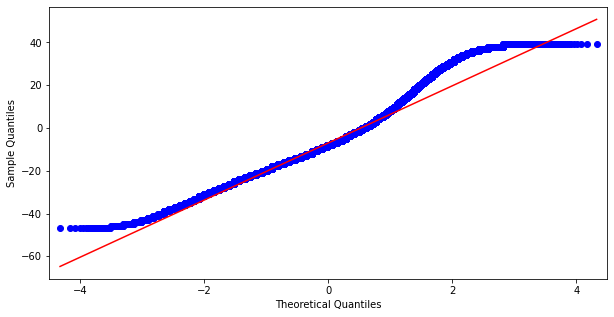

In [684]:
sm.qqplot(data=flights_fe.arr_delay,line='q')
plt.show()

<AxesSubplot:ylabel='arr_delay'>

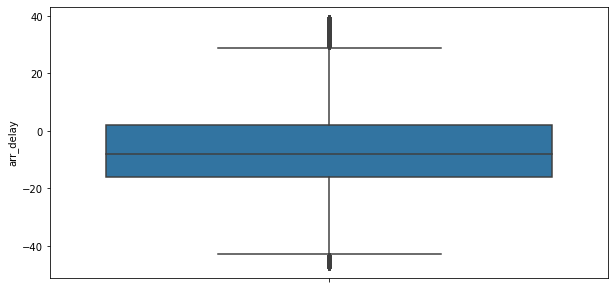

In [685]:
sns.boxplot(y=flights_fe.arr_delay)

In [686]:
flights_fe.shape

(132665, 89)

## Missing values

In [687]:
(flights_fe.isna().sum()).sort_values(ascending=False).head(15)

no_name                132665
cancellation_code      132665
total_add_gtime        132463
first_dep_time         132463
longest_add_gtime      132463
carrier_delay          119116
weather_delay          119116
nas_delay              119116
security_delay         119116
late_aircraft_delay    119116
dep_severity             3936
dep_type                 3936
arr_severity             3859
arr_type                 3859
area_or                   163
dtype: int64

In [688]:
drop_columns = (flights_fe.isna().sum()).sort_values(ascending=False).head(10).index.values

In [689]:
flights_fe = flights_fe.drop(columns=drop_columns)

In [690]:
(flights_fe.isna().sum()).sort_values(ascending=False).head(10)

dep_severity          3936
dep_type              3936
arr_severity          3859
arr_type              3859
area_or                163
area_des               159
hub_type_or             42
hub_type_des            28
Locid                   27
CY 19 Enplanements      27
dtype: int64

<AxesSubplot:xlabel='dep_severity', ylabel='count'>

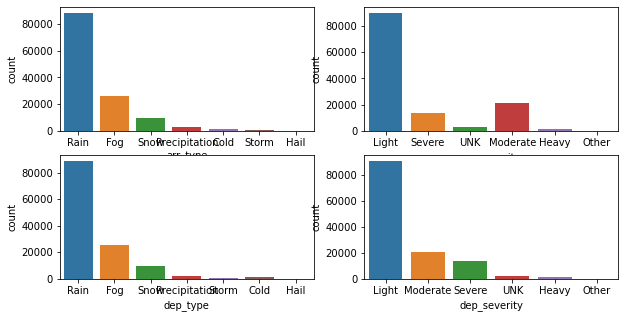

In [691]:
fig,axs = plt.subplots(2,2)
sns.countplot(x=flights_fe.arr_type,ax=axs[0][0])
sns.countplot(x=flights_fe.arr_severity,ax=axs[0][1])
sns.countplot(x=flights_fe.dep_type,ax=axs[1][0])
sns.countplot(x=flights_fe.dep_severity,ax=axs[1][1])

In [692]:
flights_fe.arr_type = flights_fe.arr_type.fillna(flights_fe.arr_type.describe().top)
flights_fe.arr_severity = flights_fe.arr_severity.fillna(flights_fe.arr_severity.describe().top)
flights_fe.dep_type = flights_fe.dep_type.fillna(flights_fe.dep_type.describe().top)
flights_fe.dep_severity = flights_fe.dep_severity.fillna(flights_fe.dep_severity.describe().top)

In [693]:
(flights_fe.isna().sum()).sort_values(ascending=False).head(10)

area_or               163
area_des              159
hub_type_or            42
hub_type_des           28
Rank_or                27
Locid                  27
CY 19 Enplanements     27
beacon_color_or        26
beacon_color_des       20
Rank_des               20
dtype: int64

In [694]:
flights_fe.dest[flights_fe.area_des.isna()].unique()

array(['GRK', 'SIT', 'ADQ', 'OME', 'DUT', 'BRW', 'PSG', 'YAK', 'WRG'],
      dtype=object)

In [695]:
flights_fe.origin[flights_fe.area_or.isna()].unique()

array(['GRK', 'SIT', 'ADQ', 'BRW', 'OME', 'ADK', 'DUT', 'PSG', 'YAK',
       'WRG'], dtype=object)

In [696]:
flights_fe.dest[flights_fe.hub_type_des.isna()].unique()

array(['JHM', 'DVL'], dtype=object)

In [697]:
flights_fe = flights_fe.dropna()
flights_fe.shape

(132286, 79)

In [1071]:
flights_fe.to_csv("train_data_Akhmet_v2.csv",index=False)

## Preprocessing

In [698]:
flights_dropped = flights_fe.copy()

In [699]:
flights_fe.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled', 'diverted', 'dup',
       'crs_elapsed_time', 'actual_elapsed_time', 'air_time', 'flights',
       'distance', 'arr_date_time', 'dep_date_time', 'arr_month',
       'origin_airport_type', 'dest_airport_type', 'inbound_flights',
       'dep_flights_count', 'arr_flights_count', 'origin_state', 'dest_state',
       'origin_population', 'dest_population', 'Locid', 'CY 19 Enplanements',
       'service_level_or', 'hub_type_or', 'ownership_status_or',
       'facility_use_or', 'area_or', 'fss_on_airport_or', 'beacon_color_or',
       'total_operations_annual_or', 'num_ru

In [700]:
test_columns = ["mkt_unique_carrier","branded_code_share",
               "mkt_carrier","mkt_carrier_fl_num",
               "op_unique_carrier","tail_num","op_carrier_fl_num",
               "origin_airport_id","origin","origin_city_name",
               "dest_airport_id","dest","dest_city_name","crs_elapsed_time",
               "flights","distance","arr_delay"]

weather_features = ['arr_type','arr_severity', 'dep_type', 'dep_severity']

population_features = ['origin_population','dest_population']

timing_features = ['arr_date_time', 'dep_date_time', 'arr_month','arr_day_of_week', 'arr_hour','dep_month', 'dep_day_of_week', 'dep_hour']

or_airport_features = ['service_level_or','hub_type_or', 'ownership_status_or', 'facility_use_or', 'area_or',
                    'fss_on_airport_or', 'beacon_color_or', 'total_operations_annual_or','num_runways_or', 
                    'avg_runway_length_or', 'avg_runway_width_or','Rank_or','CY 19 Enplanements']

dest_airport_features = ['service_level_des', 'hub_type_des', 'ownership_status_des','facility_use_des', 'area_des', 
                         'fss_on_airport_des','beacon_color_des', 'total_operations_annual_des', 'num_runways_des',
                         'avg_runway_length_des', 'avg_runway_width_des', 'Rank_des']

from_data = ['origin_airport_type','dest_airport_type', 'inbound_flights', 
             'dep_flights_count','arr_flights_count', 'origin_state', 'dest_state']

features_to_keep = test_columns+weather_features+population_features+timing_features+or_airport_features+dest_airport_features+from_data

columns_to_drop = set(flights_dropped.columns).difference(set(features_to_keep))
flights_dropped = flights_dropped.drop(columns=columns_to_drop)

In [701]:
repetitive_columns = ["branded_code_share","mkt_carrier","tail_num","mkt_carrier_fl_num",
                      "origin_airport_id","dest_airport_id","flights"]
flights_dropped = flights_dropped.drop(columns=repetitive_columns)

In [702]:
flights_dropped  = flights_dropped.drop(columns=["arr_date_time","dep_date_time"])
flights_dropped.head()

,mkt_unique_carrier,op_unique_carrier,op_carrier_fl_num,origin,origin_city_name,dest,dest_city_name,arr_delay,crs_elapsed_time,distance,...,Rank_des,arr_day_of_week,arr_hour,dep_month,dep_day_of_week,dep_hour,arr_type,arr_severity,dep_type,dep_severity
0,DL,9E,5303,ATL,"Atlanta, GA",ABE,"Allentown/Bethlehem/Easton, PA",-17.0,121.0,692.0,...,143.0,2,17,1,2,15,Rain,Light,Rain,Light
1,DL,9E,5454,ATL,"Atlanta, GA",ABE,"Allentown/Bethlehem/Easton, PA",-12.0,123.0,692.0,...,143.0,1,12,3,1,10,Rain,Light,Rain,Moderate
2,DL,9E,5443,ATL,"Atlanta, GA",ABE,"Allentown/Bethlehem/Easton, PA",-23.0,129.0,692.0,...,143.0,2,17,4,2,15,Rain,Light,Rain,Light
3,DL,9E,5371,ATL,"Atlanta, GA",ABE,"Allentown/Bethlehem/Easton, PA",5.0,123.0,692.0,...,143.0,6,12,5,6,10,Rain,Light,Rain,Light
6,DL,9E,5197,ATL,"Atlanta, GA",ABE,"Allentown/Bethlehem/Easton, PA",-29.0,132.0,692.0,...,143.0,0,17,8,0,15,Rain,Light,Rain,Light


In [703]:
flights_dropped = flights_dropped.drop(columns=["dest_city_name","dest","origin","origin_city_name"])
flights_dropped.head()

,mkt_unique_carrier,op_unique_carrier,op_carrier_fl_num,arr_delay,crs_elapsed_time,distance,arr_month,origin_airport_type,dest_airport_type,inbound_flights,...,Rank_des,arr_day_of_week,arr_hour,dep_month,dep_day_of_week,dep_hour,arr_type,arr_severity,dep_type,dep_severity
0,DL,9E,5303,-17.0,121.0,692.0,1,Very Large,Large,2,...,143.0,2,17,1,2,15,Rain,Light,Rain,Light
1,DL,9E,5454,-12.0,123.0,692.0,3,Very Large,Large,0,...,143.0,1,12,3,1,10,Rain,Light,Rain,Moderate
2,DL,9E,5443,-23.0,129.0,692.0,4,Very Large,Large,1,...,143.0,2,17,4,2,15,Rain,Light,Rain,Light
3,DL,9E,5371,5.0,123.0,692.0,5,Very Large,Large,1,...,143.0,6,12,5,6,10,Rain,Light,Rain,Light
6,DL,9E,5197,-29.0,132.0,692.0,8,Very Large,Large,1,...,143.0,0,17,8,0,15,Rain,Light,Rain,Light


In [704]:
flights_dropped.columns

Index(['mkt_unique_carrier', 'op_unique_carrier', 'op_carrier_fl_num',
       'arr_delay', 'crs_elapsed_time', 'distance', 'arr_month',
       'origin_airport_type', 'dest_airport_type', 'inbound_flights',
       'dep_flights_count', 'arr_flights_count', 'origin_state', 'dest_state',
       'origin_population', 'dest_population', 'CY 19 Enplanements',
       'service_level_or', 'hub_type_or', 'ownership_status_or',
       'facility_use_or', 'area_or', 'fss_on_airport_or', 'beacon_color_or',
       'total_operations_annual_or', 'num_runways_or', 'avg_runway_length_or',
       'avg_runway_width_or', 'Rank_or', 'service_level_des', 'hub_type_des',
       'ownership_status_des', 'facility_use_des', 'area_des',
       'fss_on_airport_des', 'beacon_color_des', 'total_operations_annual_des',
       'num_runways_des', 'avg_runway_length_des', 'avg_runway_width_des',
       'Rank_des', 'arr_day_of_week', 'arr_hour', 'dep_month',
       'dep_day_of_week', 'dep_hour', 'arr_type', 'arr_severity', 

In [1064]:
flights_modelling.to_csv("train_data_Akhmet_v2.csv",index=False)

## Modelling

In [1028]:
flights_modelling = flights_dropped.copy()

In [1029]:
X,y = flights_modelling.drop(columns=["arr_delay"]), flights_modelling["arr_delay"]

In [1030]:
X.head()

,mkt_unique_carrier,op_unique_carrier,op_carrier_fl_num,crs_elapsed_time,distance,arr_month,origin_airport_type,dest_airport_type,inbound_flights,dep_flights_count,arr_flights_count,origin_state,dest_state,origin_population,dest_population,CY 19 Enplanements,service_level_or,hub_type_or,ownership_status_or,facility_use_or,area_or,fss_on_airport_or,beacon_color_or,total_operations_annual_or,num_runways_or,avg_runway_length_or,avg_runway_width_or,Rank_or,service_level_des,hub_type_des,ownership_status_des,facility_use_des,area_des,fss_on_airport_des,beacon_color_des,total_operations_annual_des,num_runways_des,avg_runway_length_des,avg_runway_width_des,Rank_des,arr_day_of_week,arr_hour,dep_month,dep_day_of_week,dep_hour,arr_type,arr_severity,dep_type,dep_severity
0,DL,9E,5303,121.0,692.0,1,Very Large,Large,2,1,0,GA,PA,21234846.0,21234846.0,53505795.0,Primary,Large,PUBLIC,PUBLIC,4700.0,NO,Clear and Green,525305,5,9877.8,150.0,1.0,Primary,Non-Hub,PUBLIC,PUBLIC,2278.0,NO,Clear and Green,87505,2,6699.5,150.0,143.0,2,17,1,2,15,Rain,Light,Rain,Light
1,DL,9E,5454,123.0,692.0,3,Very Large,Large,0,0,0,GA,PA,21234846.0,21234846.0,53505795.0,Primary,Large,PUBLIC,PUBLIC,4700.0,NO,Clear and Green,525305,5,9877.8,150.0,1.0,Primary,Non-Hub,PUBLIC,PUBLIC,2278.0,NO,Clear and Green,87505,2,6699.5,150.0,143.0,1,12,3,1,10,Rain,Light,Rain,Moderate
2,DL,9E,5443,129.0,692.0,4,Very Large,Large,1,1,0,GA,PA,21234846.0,21234846.0,53505795.0,Primary,Large,PUBLIC,PUBLIC,4700.0,NO,Clear and Green,525305,5,9877.8,150.0,1.0,Primary,Non-Hub,PUBLIC,PUBLIC,2278.0,NO,Clear and Green,87505,2,6699.5,150.0,143.0,2,17,4,2,15,Rain,Light,Rain,Light
3,DL,9E,5371,123.0,692.0,5,Very Large,Large,1,1,0,GA,PA,21234846.0,21234846.0,53505795.0,Primary,Large,PUBLIC,PUBLIC,4700.0,NO,Clear and Green,525305,5,9877.8,150.0,1.0,Primary,Non-Hub,PUBLIC,PUBLIC,2278.0,NO,Clear and Green,87505,2,6699.5,150.0,143.0,6,12,5,6,10,Rain,Light,Rain,Light
6,DL,9E,5197,132.0,692.0,8,Very Large,Large,1,4,0,GA,PA,21234846.0,21234846.0,53505795.0,Primary,Large,PUBLIC,PUBLIC,4700.0,NO,Clear and Green,525305,5,9877.8,150.0,1.0,Primary,Non-Hub,PUBLIC,PUBLIC,2278.0,NO,Clear and Green,87505,2,6699.5,150.0,143.0,0,17,8,0,15,Rain,Light,Rain,Light


## Polynomial features

In [1031]:
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [1065]:
# original version had class ColumnExtractor(object)
# estimators need to inherit from these classes to play nicely with others
class ColumnExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_cols = X[self.columns]
        return X_cols

In [1066]:
cols_to_poly = ["distance","inbound_flights","num_runways_des","num_runways_or"]
remaining_columns = [col for col in X.columns if col not in cols_to_poly]

In [1067]:
# Using pandas get dummies to make pipeline a bit simpler by
# avoiding one-hot and label encoder.     
# Build the pipeline from a FeatureUnion that processes 
# numerical and one-hot encoded separately.
# FeatureUnion puts them back together when it's done.
pipe2nvars = Pipeline([
    ('features', FeatureUnion([('num', 
                                Pipeline([('extract', 
                                           ColumnExtractor(columns=cols_to_poly)),
                                          ('poly', 
                                           poly)  ])),
                               ('cat_var', 
                                ColumnExtractor(columns=remaining_columns))])
    )])   

In [1068]:
pipe2nvars.set_params(features__num__poly__degree=2)
X = pd.DataFrame(pipe2nvars.fit_transform(X))

In [1069]:
cols = poly.get_feature_names(input_features=cols_to_poly)+remaining_columns
cols = dict(zip(range(res.shape[1]),cols))
X = X.rename(columns=cols)

In [1070]:
X.head()

,1,distance,inbound_flights,num_runways_des,num_runways_or,distance^2,distance inbound_flights,distance num_runways_des,distance num_runways_or,inbound_flights^2,inbound_flights num_runways_des,inbound_flights num_runways_or,num_runways_des^2,num_runways_des num_runways_or,num_runways_or^2,mkt_unique_carrier,op_unique_carrier,op_carrier_fl_num,crs_elapsed_time,arr_month,origin_airport_type,dest_airport_type,dep_flights_count,arr_flights_count,origin_state,dest_state,origin_population,dest_population,CY 19 Enplanements,service_level_or,hub_type_or,ownership_status_or,facility_use_or,area_or,fss_on_airport_or,beacon_color_or,total_operations_annual_or,avg_runway_length_or,avg_runway_width_or,Rank_or,service_level_des,hub_type_des,ownership_status_des,facility_use_des,area_des,fss_on_airport_des,beacon_color_des,total_operations_annual_des,avg_runway_length_des,avg_runway_width_des,Rank_des,arr_day_of_week,arr_hour,53,54,55,56,57,58,59
0,1.0,692.0,2.0,2.0,5.0,478864.0,1384.0,1384.0,3460.0,4.0,4.0,10.0,4.0,10.0,25.0,DL,9E,5303,121.0,1,Very Large,Large,1,0,GA,PA,21234846.0,21234846.0,53505795.0,Primary,Large,PUBLIC,PUBLIC,4700.0,NO,Clear and Green,525305,9877.8,150.0,1.0,Primary,Non-Hub,PUBLIC,PUBLIC,2278.0,NO,Clear and Green,87505,6699.5,150.0,143.0,2,17,1,2,15,Rain,Light,Rain,Light
1,1.0,692.0,0.0,2.0,5.0,478864.0,0.0,1384.0,3460.0,0.0,0.0,0.0,4.0,10.0,25.0,DL,9E,5454,123.0,3,Very Large,Large,0,0,GA,PA,21234846.0,21234846.0,53505795.0,Primary,Large,PUBLIC,PUBLIC,4700.0,NO,Clear and Green,525305,9877.8,150.0,1.0,Primary,Non-Hub,PUBLIC,PUBLIC,2278.0,NO,Clear and Green,87505,6699.5,150.0,143.0,1,12,3,1,10,Rain,Light,Rain,Moderate
2,1.0,692.0,1.0,2.0,5.0,478864.0,692.0,1384.0,3460.0,1.0,2.0,5.0,4.0,10.0,25.0,DL,9E,5443,129.0,4,Very Large,Large,1,0,GA,PA,21234846.0,21234846.0,53505795.0,Primary,Large,PUBLIC,PUBLIC,4700.0,NO,Clear and Green,525305,9877.8,150.0,1.0,Primary,Non-Hub,PUBLIC,PUBLIC,2278.0,NO,Clear and Green,87505,6699.5,150.0,143.0,2,17,4,2,15,Rain,Light,Rain,Light
3,1.0,692.0,1.0,2.0,5.0,478864.0,692.0,1384.0,3460.0,1.0,2.0,5.0,4.0,10.0,25.0,DL,9E,5371,123.0,5,Very Large,Large,1,0,GA,PA,21234846.0,21234846.0,53505795.0,Primary,Large,PUBLIC,PUBLIC,4700.0,NO,Clear and Green,525305,9877.8,150.0,1.0,Primary,Non-Hub,PUBLIC,PUBLIC,2278.0,NO,Clear and Green,87505,6699.5,150.0,143.0,6,12,5,6,10,Rain,Light,Rain,Light
4,1.0,692.0,1.0,2.0,5.0,478864.0,692.0,1384.0,3460.0,1.0,2.0,5.0,4.0,10.0,25.0,DL,9E,5197,132.0,8,Very Large,Large,4,0,GA,PA,21234846.0,21234846.0,53505795.0,Primary,Large,PUBLIC,PUBLIC,4700.0,NO,Clear and Green,525305,9877.8,150.0,1.0,Primary,Non-Hub,PUBLIC,PUBLIC,2278.0,NO,Clear and Green,87505,6699.5,150.0,143.0,0,17,8,0,15,Rain,Light,Rain,Light


## One hot encoding

In [1038]:
X_dummy = X.drop(columns=["op_carrier_fl_num","crs_elapsed_time",
                          'origin_airport_type','dest_airport_type',
                         ])

In [1039]:
X_dummy = pd.get_dummies(
    data=X_dummy,columns=["mkt_unique_carrier","op_unique_carrier"])

X_dummy = pd.get_dummies(
    data=X_dummy,columns=['arr_month','arr_day_of_week', 'arr_hour',
                          'dep_month', 'dep_day_of_week', 'dep_hour',])

X_dummy = pd.get_dummies(
    data=X_dummy,columns=['service_level_or','hub_type_or', 'ownership_status_or', 'facility_use_or','fss_on_airport_or','beacon_color_or',])

X_dummy = pd.get_dummies(
    data=X_dummy,columns=['hub_type_des', 'ownership_status_des','facility_use_des', 'fss_on_airport_des','beacon_color_des','service_level_des',])

X_dummy = pd.get_dummies(
    data=X_dummy,columns=['origin_state', 'dest_state',])

X_dummy = pd.get_dummies(
    data=X_dummy,columns=['arr_type','arr_severity', 'dep_type', 'dep_severity'])      

X_dummy.shape

(132286, 296)

In [1040]:
X_dummy.columns

Index(['distance', 'inbound_flights', 'dep_flights_count', 'arr_flights_count',
       'origin_population', 'dest_population', 'CY 19 Enplanements', 'area_or',
       'total_operations_annual_or', 'num_runways_or',
       ...
       'dep_type_Precipitation', 'dep_type_Rain', 'dep_type_Snow',
       'dep_type_Storm', 'dep_severity_Heavy', 'dep_severity_Light',
       'dep_severity_Moderate', 'dep_severity_Other', 'dep_severity_Severe',
       'dep_severity_UNK'],
      dtype='object', length=296)

In [1041]:
pd.set_option('display.max_columns', None)
X_dummy.head()

,distance,inbound_flights,dep_flights_count,arr_flights_count,origin_population,dest_population,CY 19 Enplanements,area_or,total_operations_annual_or,num_runways_or,avg_runway_length_or,avg_runway_width_or,Rank_or,area_des,total_operations_annual_des,num_runways_des,avg_runway_length_des,avg_runway_width_des,Rank_des,mkt_unique_carrier_AA,mkt_unique_carrier_AS,mkt_unique_carrier_B6,mkt_unique_carrier_DL,mkt_unique_carrier_F9,mkt_unique_carrier_G4,mkt_unique_carrier_HA,mkt_unique_carrier_NK,mkt_unique_carrier_UA,mkt_unique_carrier_WN,op_unique_carrier_9E,op_unique_carrier_AA,op_unique_carrier_AS,op_unique_carrier_AX,op_unique_carrier_B6,op_unique_carrier_C5,op_unique_carrier_CP,op_unique_carrier_DL,op_unique_carrier_EM,op_unique_carrier_EV,op_unique_carrier_F9,op_unique_carrier_G4,op_unique_carrier_G7,op_unique_carrier_HA,op_unique_carrier_MQ,op_unique_carrier_NK,op_unique_carrier_OH,op_unique_carrier_OO,op_unique_carrier_PT,op_unique_carrier_QX,op_unique_carrier_UA,op_unique_carrier_WN,op_unique_carrier_YV,op_unique_carrier_YX,op_unique_carrier_ZW,arr_month_1,arr_month_2,arr_month_3,arr_month_4,arr_month_5,arr_month_6,arr_month_7,arr_month_8,arr_month_9,arr_month_10,arr_month_11,arr_month_12,arr_day_of_week_0,arr_day_of_week_1,arr_day_of_week_2,arr_day_of_week_3,arr_day_of_week_4,arr_day_of_week_5,arr_day_of_week_6,arr_hour_0,arr_hour_1,arr_hour_2,arr_hour_3,arr_hour_4,arr_hour_5,arr_hour_6,arr_hour_7,arr_hour_8,arr_hour_9,arr_hour_10,arr_hour_11,arr_hour_12,arr_hour_13,arr_hour_14,arr_hour_15,arr_hour_16,arr_hour_17,arr_hour_18,arr_hour_19,arr_hour_20,arr_hour_21,arr_hour_22,arr_hour_23,dep_month_1,dep_month_2,dep_month_3,dep_month_4,dep_month_5,dep_month_6,dep_month_7,dep_month_8,dep_month_9,dep_month_10,dep_month_11,dep_month_12,dep_day_of_week_0,dep_day_of_week_1,dep_day_of_week_2,dep_day_of_week_3,dep_day_of_week_4,dep_day_of_week_5,dep_day_of_week_6,dep_hour_0,dep_hour_1,dep_hour_2,dep_hour_3,dep_hour_4,dep_hour_5,dep_hour_6,dep_hour_7,dep_hour_8,dep_hour_9,dep_hour_10,dep_hour_11,dep_hour_12,dep_hour_13,dep_hour_14,dep_hour_15,dep_hour_16,dep_hour_17,dep_hour_18,dep_hour_19,dep_hour_20,dep_hour_21,dep_hour_22,dep_hour_23,service_level_or_Primary,hub_type_or_Large,hub_type_or_Medium,hub_type_or_Non-Hub,hub_type_or_Small,ownership_status_or_AIR FORCE,ownership_status_or_NAVY,ownership_status_or_PUBLIC,facility_use_or_PUBLIC,fss_on_airport_or_NO,fss_on_airport_or_YES,beacon_color_or_Clear and Green,hub_type_des_Large,hub_type_des_Medium,hub_type_des_Non-Hub,hub_type_des_Small,ownership_status_des_AIR FORCE,ownership_status_des_NAVY,ownership_status_des_PUBLIC,facility_use_des_PUBLIC,fss_on_airport_des_NO,fss_on_airport_des_YES,beacon_color_des_Clear and Green,service_level_des_Primary,origin_state_AK,origin_state_AL,origin_state_AR,origin_state_AZ,origin_state_CA,origin_state_CO,origin_state_CT,origin_state_DC,origin_state_FL,origin_state_GA,origin_state_HI,origin_state_IA,origin_state_ID,origin_state_IL,origin_state_IN,origin_state_KS,origin_state_KY,origin_state_LA,origin_state_MA,origin_state_MD,origin_state_ME,origin_state_MI,origin_state_MN,origin_state_MO,origin_state_MS,origin_state_MT,origin_state_NC,origin_state_ND,origin_state_NE,origin_state_NH,origin_state_NJ,origin_state_NM,origin_state_NV,origin_state_NY,origin_state_OH,origin_state_OK,origin_state_OR,origin_state_PA,origin_state_PR,origin_state_RI,origin_state_SC,origin_state_SD,origin_state_TN,origin_state_TT,origin_state_TX,origin_state_UT,origin_state_VA,origin_state_VI,origin_state_VT,origin_state_WA,origin_state_WI,origin_state_WV,origin_state_WY,dest_state_AK,dest_state_AL,dest_state_AR,dest_state_AZ,dest_state_CA,dest_state_CO,dest_state_CT,dest_state_DC,dest_state_FL,dest_state_GA,dest_state_HI,dest_state_IA,dest_state_ID,dest_state_IL,dest_state_IN,dest_state_KS,dest_state_KY,dest_state_LA,dest_state_MA,dest_state_MD,dest_state_ME,dest_state_MI,dest_state_MN,dest_state_MO,dest_state_MS,dest_state_MT,dest_state_NC,dest_state_ND,dest_state_NE,dest_sta

In [1042]:
# scaler= StandardScaler()
scaler = MinMaxScaler()

In [1043]:
X_dummy = scaler.fit_transform(X=X_dummy)

In [1044]:
X_dummy.shape

(132286, 296)

## Feature Importance

In [1045]:

#transformation
#scale features

# polynomial regression
# p-value for coefficients

#

In [1046]:
from sklearn.feature_selection import SelectKBest,f_regression

In [1047]:
selector = SelectKBest(f_regression, k=200)
X_new = selector.fit_transform(X_dummy, y)

D:\Anaconda\envs\geo_env\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [1048]:
# pd.DataFrame({'columns':X_dummy.columns,'scores':selector.scores_}).sort_values(by=["scores"],ascending=False).head(20)

In [1049]:
X_train,X_test,y_train,y_test = train_test_split(X_new,y,train_size=0.7,random_state=1234)

In [1050]:
reg = LinearRegression()
model = GridSearchCV(reg,param_grid={})
model.fit(X_train,y_train)

GridSearchCV(estimator=LinearRegression(), param_grid={})

In [1051]:
y_pred = model.predict(X_test)

In [1052]:
print(r2_score(y_test,y_pred))

0.03549887826567388


In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
params = {'criterion' : ['mse'],'n_estimators':[100]}

In [ ]:
reg = RandomForestRegressor()
model = GridSearchCV(reg,param_grid=params)
model.fit(X_train,y_train)

In [ ]:
y_pred = model.predict(X_test)
print(r2_score(y_test,y_pred))

In [576]:
import xgboost as xgb

In [1053]:
#  [ {'booster':'gbtree',"verbosity":[2],'eta':uniform(0.01,0.3),"max_depth":uniform(1,6),"n_estimators":[1000]},
params =  [{'booster':['gbtree'],"verbosity":[2],'eta':[0.01,0.3],"max_depth":[3,6],"n_estimators":[1000]}]

In [1054]:

xgb_r = xgb.XGBRegressor(objective='reg:squarederror')

random_search = GridSearchCV(xgb_r, param_grid=params,scoring='r2', verbose=3)


random_search.fit(X_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[09:07:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:07:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:07:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:07:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:07:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:07:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tre

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
      

In [1055]:
# Predict the model
pred = random_search.predict(X_test)

r2_score(y_test, pred)

0.044340874690595555

In [1059]:
gamma_model = sm.GLM(y_train,X_train)

In [1060]:
gamma_results = gamma_model.fit()

In [1063]:
gamma_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              arr_delay   No. Observations:                92600
Model:                            GLM   Df Residuals:                    92422
Model Family:                Gaussian   Df Model:                          177
Link Function:               identity   Scale:                          214.41
Method:                          IRLS   Log-Likelihood:            -3.7984e+05
Date:                Thu, 29 Jul 2021   Deviance:                   1.9816e+07
Time:                        10:02:04   Pearson chi2:                 1.98e+07
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -3.3463      0.537     -6.228      0.000      -4.399      -2.293
x2             2.6973      0.749      3.601      0.000       1.229       4.165
x3             2.5866      0.636      4.070      0.000       1.341       3.832
x4             0.9350      0.527      1.773      0.076      -0.099       1.969
x5            -2.9215      1.387     -2.106      0.035      -5.640      -0.203
x6            -2.9215      1.387     -2.106      0.035      -5.640      -0.203
x7            -2.2146      0.726     -3.051      0.002      -3.637      -0.792
x8             1.6879      0.723      2.334      0.020       0.270       3.105
x9             3.7116      0.770      4.823      0.000       2.203       5.220
x10            0.0920      0.611      0.151      0.880      -1.105       1.289
x11           -0.8990      0.524     -1.716      0.086      -1.926       0.128
x12            0.2251      2.421      0.093      0.926      -4.519       4.969
x13           -0.2365      1.315     -0.180      0.857      -2.814       2.341
x14           -0.6877      0.667     -1.032      0.302      -1.994       0.619
x15           -0.6108      0.530     -1.152      0.249      -1.650       0.429
x16           -0.6809      0.420     -1.619      0.105      -1.505       0.143
x17           -0.6043      2.397     -0.252      0.801      -5.302       4.093
x18           -3.2075      1.236     -2.595      0.009      -5.630      -0.785
x19            1.5098      0.465      3.246      0.001       0.598       2.422
x20            0.8678      0.490      1.771      0.077      -0.092       1.828
x21           -0.0022      0.243     -0.009      0.993      -0.478       0.474
x22            0.0778      0.486      0.160      0.873      -0.874       1.030
x23            1.8209      0.302      6.035      0.000       1.230       2.412
x24            6.9061      0.871      7.930      0.000       5.199       8.613
x25           -0.1335      0.245     -0.544      0.586      -0.614       0.347
x26            0.4069      0.419      0.971      0.332      -0.415       1.228
x27            0.7968      0.205      3.889      0.000       0.395       1.198
x28           -2.1314      0.391     -5.450      0.000      -2.898      -1.365
x29           -0.2037      0.291     -0.700      0.484      -0.774       0.367
x30           -0.0022      0.243     -0.009      0.993      -0.478       0.474
x31            3.3969      0.658      5.160      0.000       2.107       4.687
x32           -0.4577      0.310     -1.477      0.140      -1.065       0.150
x33            5.5498      1.307      4.248      0.000       2.989       8.111
x34            1.3875      0.445      3.120      0.002       0.516       2.259
x35            1.8209      0.302      6.035      0.000       1.230       2.412
x36           -2.2471      0.544     -4.130      0.000      -3.314      -1.181
x3